# Intro to simple text classification in keras

In [1]:
# Do our imports
import numpy as np
import tensorflow as tf
from keras.models import Sequential #base keras model
from keras.layers import Dense, Activation #dense = fully connected layer
from tensorflow.keras.optimizers.legacy import SGD #this is just tensorflow.keras.optimizers on earlier versions of tf

Note: The following cell will give you an error like "No module named 'matplotlib'" if you have not yet installed matplotlib or sklearn. To install it, open up a terminal/command window, activate your environment (e.g., `conda activate coding3`), and then type `conda install matplotlib` and `conda install scikit-learn`

You may have to restart the kernel if the cell does not complete running after you install.

Note that you will only ever have to do this once per environment (e.g., from now on, when you run a new notebook that imports from matplotlib using this same environment, it will also be able to use that library; no need to install again)

In [2]:
#if any of these give you problems, make sure you've installed all libraries used (pandas, sklearn, and matplot lib)
# using conda install or pip install
# see the moodle page "Instructions for setting up and using Python and Jupyter" for more info on how to do this
import pandas as pd
import matplotlib
from sklearn.feature_extraction import _stop_words
from sklearn.metrics.pairwise import cosine_similarity as cosine
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Loading a dataset

Here's how to load in the dataset into the notebook:

In [3]:
# This assumes the IMDBsubset.csv file lives in a directory called "data" which lives in the same directory as this notebook.
# ***if you want to edit this notebook to use a different dataset, edit this to specify a different file:
df = pd.read_csv("data/depression_dataset.csv")

Now we've got the data read in! We've used a special data type called a "data frame", using the Pandas library, to store this data. Pandas makes working with data pretty convenient.

Printing df will show you the data in a table-like format (specifically, it'll show you the first and last few rows of the table).

**Note that a sentiment of "1" means "depressive" and "0" means "nondepressive"**

In [4]:
df

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1
...,...,...
7726,is that snow,0
7727,moulin rouge mad me cry once again,0
7728,trying to shout but can t find people on the list,0
7729,ughh can t find my red sox hat got ta wear thi...,0


This is great, but if we want to read the full reviews (handy for later) then we can change our display options:

In [5]:
pd.set_option('display.max_colwidth', None) #show me everything in the column, even if it's long!
df #Show me the first and last few examples

clean_text   
0     we understand that most people who reply immediately to an op with an invitation to talk privately mean only to help but this type of response usually lead to either disappointment or disaster it usually work out quite differently here than when you say pm me anytime in a casual social context we have huge admiration and appreciation for the goodwill and good citizenship of so many of you who support others here and flag inappropriate content even more so because we know that so many of you are struggling yourselves we re hard at work behind the scene on more information and resource to make it easier to give and get quality help here this is just a small start our new wiki page explains in detail why it s much better to respond in public comment at least until you ve gotten to know someone it will be maintained at r depression wiki private contact and the full text of the current version is below summary anyone who while acting a a helper invite or accepts private contact i e pm chat or any kind of offsite communication early in the conversion is showing either bad intention or bad judgement either way it s unwise to trust them pm me anytime seems like a kind and generous offer and it might be perfectly well meaning but unless and until a solid rapport ha been established it s just not a wise idea here are some point to consider before you offer or accept an invitation to communicate privately by posting supportive reply publicly you ll help more people than just the op if your response are of good quality you ll educate and inspire other helper the 9 90 rule http en wikipedia org wiki rule internet culture applies here a much a it doe anywhere else on the internet people who are struggling with serious mental health issue often justifiably have a low tolerance for disappointment and a high level of ever changing emotional need unless the helper is able to make a 00 commitment to be there for them in every way for a long a necessary offering a personal inbox a a resource is likely to do more harm than good this is why mental health crisis line responder usually don t give their name and caller aren t allowed to request specific responder it s much healthier and safer for the caller to develop a relationship with the agency a a whole analogously it s much safer and healthier for our ops to develop a relationship with the community a a whole even trained responder are generally not allowed to work high intensity situation alone it s partly about availability but it s mostly about wider perspective and preventing compassion fatigue if a helper get in over their head with someone whose mental health issue including suicidality which is often comorbid with depression escalate in a pm conversation it s much harder for others including the r depression and r suicidewatch moderator to help contrary to common assumption moderator can t see or police pm in our observation over many year the people who say pm me the most are consistently the one with the least understanding of mental health issue and mental health support we all have gap in our knowledge and in our ability to communicate effectively community input mitigates these limitation there s no reason why someone who s truly here to help would want to hide their response from community scrutiny if helper are concerned about their own privacy keep in mind that self disclosure when used supportively is more about the feeling than the detail and that we have no problem here with the use of alt throwaway account and have no restriction on account age or karma we all know the internet is used by some people to exploit or abuse others these people do want to hide their deceptive and manipulative response from everyone except their victim there are many of them who specifically target those who are vulnerable because of mental health issue if a helper invite an op to talk privately and give them a good supportive experience they ve primed that person to be more vuln

Let's do something super simple to transform this into a dataset that we can send to a neural network. 

Similarly to the sentiment classification we discussed in lecture last week, we're going to represent each example (review) as a vector of word counts.

The CountVectorizer object from sklearn allows us to make these word count vectors pretty easily. Once we do the counts, we'll store these in a new dataframe.


The following code transforms a review dataframe to a word count dataframe called wordcounts.

In [6]:
# Transform a dataframe containing a column named "review" 
# such that each row becomes represented by a set of word counts, corresponding to the number of each term in the review

#These next two lines perform word counting:
vectorizer = CountVectorizer(stop_words='english', min_df=0.01)
#stop_words='english' removes very common english words that are unlikely to be useful (e.g. "and", "the")
#min_df=0.1 removes very rare words that are likely to be typos, uninformative, etc.
# You can type ?CountVectorizer in its own cell to read its documentation
#***Note that "df['review']" is used below because "review" is the name of the column containing our text in the dataframe
#If you apply this to your own data, you may probably need to change this column name!
matrix = vectorizer.fit_transform(df['clean_text'])
    
#This line converts matrix into another dataframe, with column names corresponding to the word being counted
data = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names_out())

Take a look at the data:

In [7]:
data #prints data to screen

,00,able,absolutely,actually,advice,afraid,age,ago,alive,amp,...,worse,worst,worth,wouldn,writing,wrong,yeah,year,yes,yesterday
0,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7726,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7727,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7728,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7729,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Note that you can examine this dataset, e.g. to look at the column of counts for the word "suicide":

In [8]:
data["suicide"]

0       0
1       0
2       0
3       0
4       0
       ..
7726    0
7727    0
7728    0
7729    0
7730    0
Name: suicide, Length: 7731, dtype: int64

In [9]:
data["anxiety"]

0       0
1       0
2       1
3       0
4       0
       ..
7726    0
7727    0
7728    0
7729    0
7730    0
Name: anxiety, Length: 7731, dtype: int64

## Let's do some machine learning!

In [10]:
#First, let's split our dataset into training and test sets
# Remember: X is for input, y is for output
# The first argument of train_test_split is your training data (here, lives in "data" object you created using word counts)
# The second argument of train_test_split is your labels/targets for the training data. This lives in the "sentiment" column of the original dataframe df we loaded from the file.
# (***If you are using a different dataset, you'll need to change the name of this column to whatever it is in your dataset)
# The test_size argument specifies % of data going into test set: here, 20% of the data goes into test set and 80% goes into training set
X_train, X_test, y_train, y_test = train_test_split(data, df['is_depression'], test_size=0.2, random_state=0)

In [11]:
#If you ever want to learn more about a function, you can always use ? 
?train_test_split

In [12]:
# We can examine it a bit using np.shape:
np.shape(X_train) #What does our training data look like? It's 800 rows, with 1674 dimensions of input (features)

(6184, 433)

In [13]:
#Now let's make a simple neural network with 1 hidden layer containing 10 neurons
num_neurons = 100 # neurons in each layer
model = Sequential()

#Make the first (hidden) layer, which will have num_neurons neurons. Each neuron will get inputs from all columns of the dataframe, except sentiment
#model.add(Dense(num_neurons, input_dim=len(data.columns)-1))
model.add(Dense(num_neurons, input_dim=np.shape(X_train)[1]))
model.add(Activation('sigmoid')) #Now we'll use a sigmoid activation function

#Now let's add another layer for the output: A single sigmoid neuron.
model.add(Dense(1)) 
model.add(Activation('sigmoid'))

Metal device set to: Apple M1 Pro


In [14]:
#Use compile() to set up our training

# For loss, we'll use binary cross-entropy loss, 
# which is appropriate for a binary classification problem (0/1 for negative/positive)
# ***If you edit this notebook to apply it to a multi-class classification problem, you'll need 
#    to change the loss to something like categorical_crossentropy, and you'll also need to change the
#    encoding of the class to a one hot representation (see https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)


model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [27]:
#Train it!
# Plus store history of training in a variable called "history"
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
194/194 [==============================] - 1s 6ms/step - loss: 0.2923 - accuracy: 0.9020 - val_loss: 0.2960 - val_accuracy: 0.9076
Epoch 2/10
194/194 [==============================] - 1s 6ms/step - loss: 0.2845 - accuracy: 0.9085 - val_loss: 0.2885 - val_accuracy: 0.9050
Epoch 3/10
194/194 [==============================] - 1s 6ms/step - loss: 0.2773 - accuracy: 0.9099 - val_loss: 0.2824 - val_accuracy: 0.9218
Epoch 4/10
194/194 [==============================] - 1s 6ms/step - loss: 0.2707 - accuracy: 0.9187 - val_loss: 0.2753 - val_accuracy: 0.9192
Epoch 5/10
194/194 [==============================] - 1s 6ms/step - loss: 0.2642 - accuracy: 0.9246 - val_loss: 0.2693 - val_accuracy: 0.9218
Epoch 6/10
194/194 [==============================] - 1s 6ms/step - loss: 0.2581 - accuracy: 0.9342 - val_loss: 0.2637 - val_accuracy: 0.9360
Epoch 7/10
194/194 [==============================] - 1s 6ms/step - loss: 0.2524 - accuracy: 0.9413 - val_loss: 0.2584 - val_accuracy: 0.9367
Epoch 

Let's take a look at how training set and test set accuracy change with each epoch:

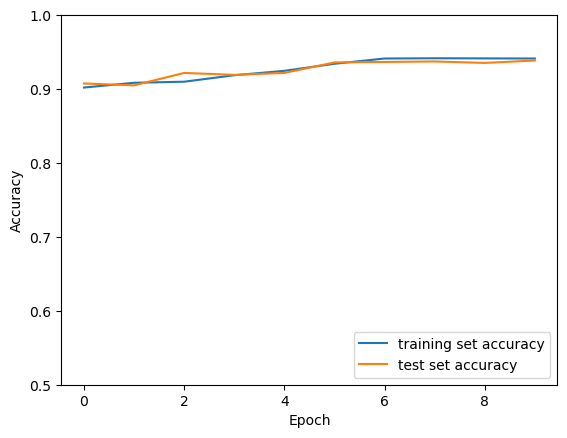

In [28]:
plt.plot(history.history['accuracy'], label='training set accuracy')
plt.plot(history.history['val_accuracy'], label = 'test set accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

## Examining model behaviour

First, let's explore how we can apply the trained model to a specific example in our test data (or training data), to examine what it's done.

We'll use the following code techniques:
* We can apply the trained model to any example using the `.predict()` function
* We can get the nth row from any dataframe using the `.iloc[[n]]` function

In [29]:
#For instance, let's make z the first test example:
z = X_test.iloc[[0]]

#and let's output the prediction for this example:
model.predict(z)

1/1 [==============================] - 0s 15ms/step


array([[0.9260325]], dtype=float32)

Note that this prediction will be somewhere between 0 and 1. This can be interpreted loosely as confidence: closer to 1 is more confident it is depressive, closer to 0 is more confident it is nondepressive.

Let's compare this to the actual sentiment of the review, as stored in y_test:

In [30]:
y_test.iloc[[0]]

3311    1
Name: is_depression, dtype: int64

To make sense of this, we probably also want to look at the actual text review, which doesn't live in X_test but does live in the original dataframe we loaded from the CSV file, i.e. `df`. Since our `train_test_split` function has randomised the order of the data before splitting into training and testing sets, we need to get the id (row number) for `df` corresponding to this first test example.

In [31]:
test_ids = list(X_test.index) #gets the original indices in the df dataframe
#test_ids[n] now refers to the id number of the nth test example
originalText = df.iloc[[test_ids[0]]].clean_text
originalText

3311    y all throw the depression word all over nje mme o ikadima di ayashisa amatakkie nywe nywe spiral to depression
Name: clean_text, dtype: object

Try this with a few more examples and see what you find. If you're comfortable with python, can you think of a way to identify misclassified test examples and just print out those? Or, even better, find test examples that are confidently classified correctly, or test examples that are "confidently" misclassified, and examine those?

For more fun, how about testing this classifier on our own new, fake "reviews"? Here's code to create an example of your own and apply the classifier to it. We'll have to first convert a string of text to a vector of word counts and put it in a dataframe, so here's a function for that:

In [32]:
# Turns a text string into a dataframe example (***Note you'll need to change this from 'review' for your own dataset)
def createExample(myText):

    newExample = np.array([[myText]])
    tdf = pd.DataFrame(newExample, columns=["clean_text"])
    matrix = vectorizer.transform(tdf['clean_text'])
    newDf = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names_out())
    return newDf 

In [33]:
#Here's a text about depression
myText = "i m sitting on my bed alone in my dark room smoking weed looking at the night sky and old photo listening to music i wa listening year ago and thinking about those time when everything wa fine and i knew le than i know right know it hurt so much physically and mentally"
t = createExample(myText) 
t

,00,able,absolutely,actually,advice,afraid,age,ago,alive,amp,...,worse,worst,worth,wouldn,writing,wrong,yeah,year,yes,yesterday
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [34]:
#apply the model to classify your new text:
model.predict(t)

1/1 [==============================] - 0s 13ms/step


array([[0.7620112]], dtype=float32)

In [35]:
model.predict(createExample("I went shopping with my friends today."))

1/1 [==============================] - 0s 14ms/step


array([[0.12497906]], dtype=float32)

In [36]:
model.predict(createExample("I'm so happy."))

1/1 [==============================] - 0s 14ms/step


array([[0.13012855]], dtype=float32)

## Explore on your own

Change the code above to explore:
* Does changing the number of neurons in the hidden layer change the results? What happens to accuracy when you use 1 neuron? 100 neurons? 
* Try editing the neural network so that you have 2 hidden layers of 10 neurons each. What happens to accuracy? 

Investigating the model
* Can you examine the model's performance on the test data to discover anything about what mistakes this model makes? Or anything about what types of reviews are easy to classify accurately?
* Can you come up with your own, new examples of positive or negative reviews that illustrate the mistakes the model makes?

EXAMPLE for peoblem:

In [37]:
model.predict(createExample("I want to kill myself."))

1/1 [==============================] - 0s 15ms/step


array([[0.20332897]], dtype=float32)